Investigate using supContrast to train data from other agents.
1. Train one agent on [1, 2]
2. Feed exact [1, 2] more data to the agents using supcontrast to see if the downstream performance would improve?
3. Feed only [1] to see if this is going to improve?
4. TODO: test zero-shot generalization across random projection.

In [1]:
from shell.datasets.datasets import get_dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from shell.utils.utils import seed_everything
import torch
import subprocess
import torch.nn as nn
import torch
import os
from omegaconf import DictConfig
from shell.datasets.datasets import get_dataset
from shell.utils.utils import seed_everything
from pprint import pprint
from shell.fleet.network import TopologyGenerator
from shell.models.cnn_soft_lifelong_dynamic import CNNSoftLLDynamic
from shell.models.cnn import CNN
from shell.models.mlp import MLP
from shell.models.mlp_soft_lifelong_dynamic import MLPSoftLLDynamic
from shell.learners.er_dynamic import CompositionalDynamicER
from shell.learners.er_nocomponents import NoComponentsER
from shell.utils.experiment_utils import eval_net
from shell.utils.experiment_utils import setup_experiment
from sklearn.manifold import TSNE
import logging
import seaborn as sns
logging.basicConfig(level=logging.INFO)


seed_everything(0)

In [2]:
data_cfg = {
    "dataset_name": "kmnist",
    # "dataset_name": "fashionmnist",
    "num_tasks": 1,
    "num_train_per_task": 128,
    "labels": np.array([1, 2]),
    'remap_labels': True,
}
dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [1 2]
INFO:root:(128, 1, 28, 28)


In [3]:
dataset2 = get_dataset(**data_cfg)

INFO:root:Class sequence: [1 2]
INFO:root:(128, 1, 28, 28)


In [4]:
X1 = dataset.trainset[0].tensors[0]
X2 = dataset2.trainset[0].tensors[0]

dataset.trainset[0].tensors[1], len(dataset.trainset[0].tensors[1])

(tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
         1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
         1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 0, 1, 0, 0, 0, 1]),
 128)

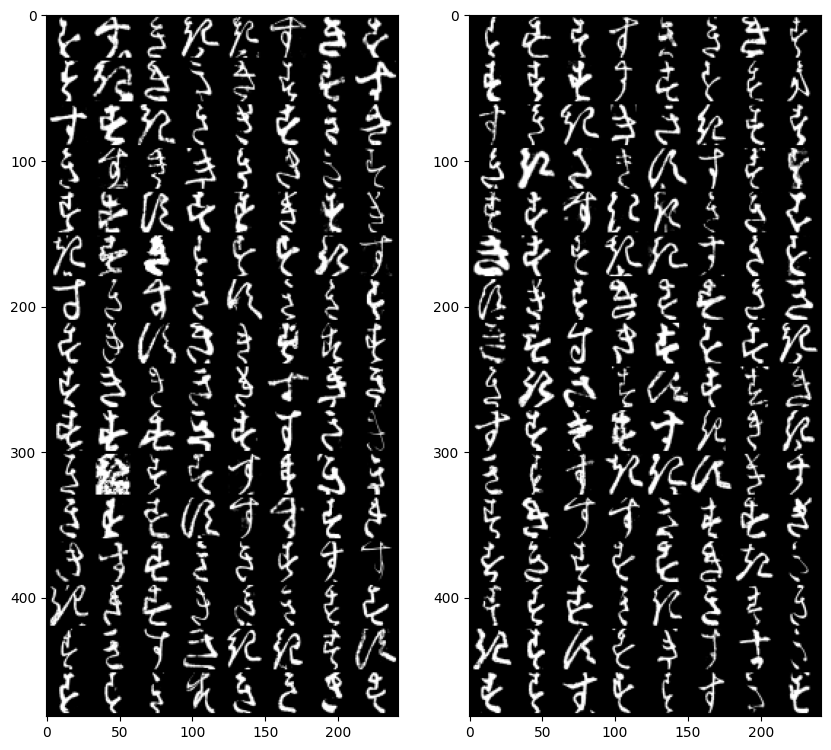

In [5]:
img1 = make_grid(X1, nrow=8)
img2 = make_grid(X2, nrow=8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))

plt.subplot(1, 2, 2)

plt.imshow(img2.permute(1, 2, 0));

In [6]:
# ## TRICKY PONNY: flip the labels for the dataset2
# Y_flipped = 1.0 - dataset2.trainset[0].tensors[1]
# dataset2.trainset[0] = torch.utils.data.TensorDataset(X2, Y_flipped.long())

In [7]:
task_id = 0
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         num_workers=0,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}
testloaders

{0: <torch.utils.data.dataloader.DataLoader at 0x7f915efc3b80>}

In [8]:
"""
Define NetCls and AgentCls
"""

net_cfg = {
    'depth': 2,
    'layer_size': 64,
    'num_init_tasks': -1,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': 1,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': True,
}
net = MLP(**net_cfg)
agent = NoComponentsER(net, **agent_cfg)

In [9]:
eval_net(net, testloaders)

{0: 0.501}

In [10]:
print(net)
print(len(net.components))

MLP(
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
  )
  (components): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): ModuleList(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
)
2


In [11]:
"""
There are automatic transformation technique like RandAug, AugMix.
"""

'\nThere are automatic transformation technique like RandAug, AugMix.\n'

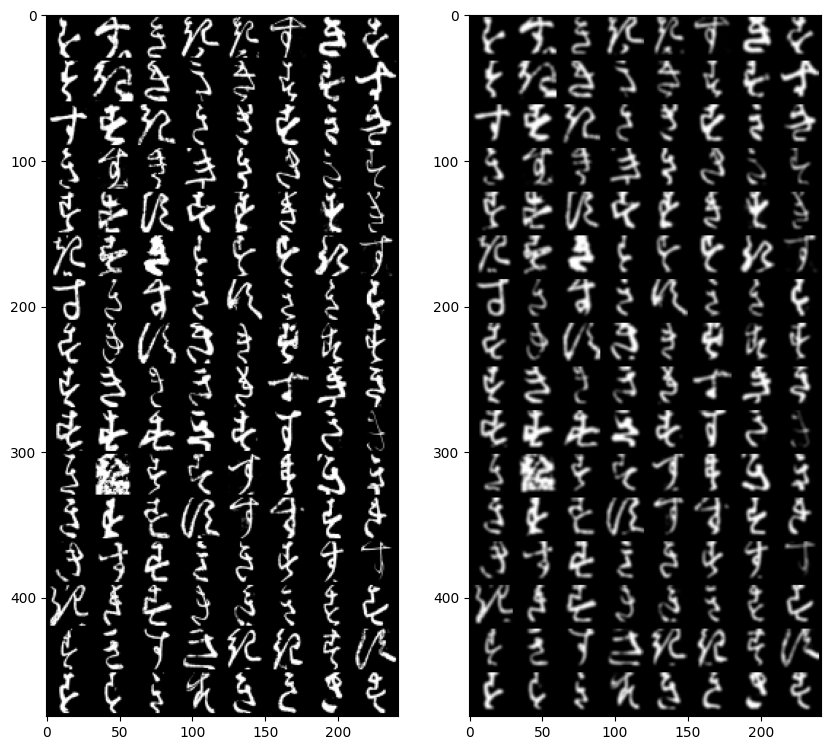

In [12]:
import torchvision.transforms as transforms
# def aug(X, Y):
#     # train_transform = transforms.Compose([
#     #                 transforms.RandomResizedCrop(
#     #                     size=28, scale=(0.2, 1.), antialias=True),
#     #                 transforms.RandomHorizontalFlip(),
#     #                 transforms.RandomApply([
#     #                     transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
#     #                 ], p=0.8),
#     #                 transforms.RandomGrayscale(p=0.2),
#     #             ])
#     # use GaussianBlur
#     train_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))

#     return train_transform(X) 

# def aug(X, y):
#     return mixup(X, y, 0.2)

# print(agent.train_transform)
Y1 = dataset.trainset[0].tensors[1]
X1_a = agent.train_transform(X1)

# transform = transforms.ColorJitter(brightness=0.2, contrast=0.2)

# print(transform)
# X1_a = transform(X1)

img1 = make_grid(X1, nrow=8)
img2 = make_grid(X1_a, nrow=8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))

plt.subplot(1, 2, 2)

plt.imshow(img2.permute(1, 2, 0));

In [13]:
X1.max()

tensor(1.)

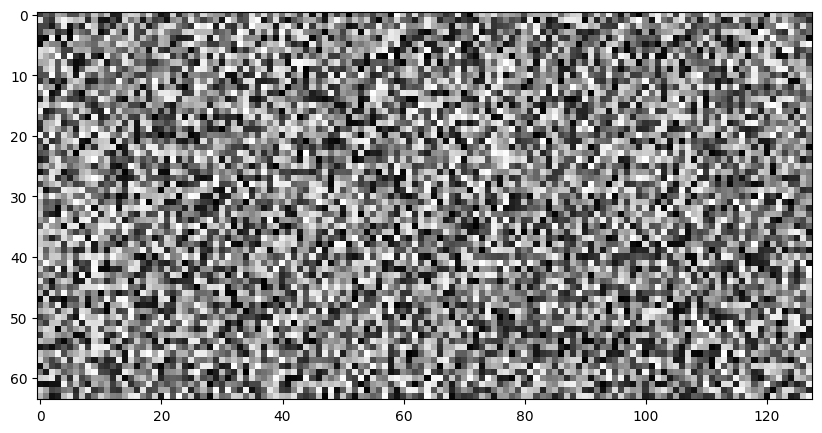

In [14]:
# visualize the weights of the net
# get all the weights from net.components to a big matrix, then plt.imshow

comp_weights_before = []
for i in range(len(net.components)):
    comp_weights_before.append(net.components[i].weight.detach().cpu().numpy())
comp_weights_before = np.concatenate(comp_weights_before, axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(comp_weights_before, cmap='gray');


(2, 64)


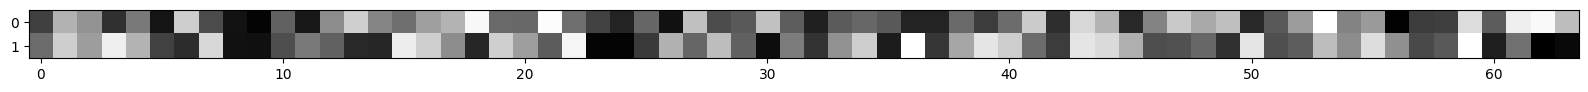

In [15]:
# visualize the decoder (classifier), weights is from net.decoder[task_id]
cls_weights_before = net.decoder[task_id].weight.detach().cpu().numpy()
print(cls_weights_before.shape)
plt.figure(figsize=(20, 10))
plt.imshow(cls_weights_before, cmap='gray');

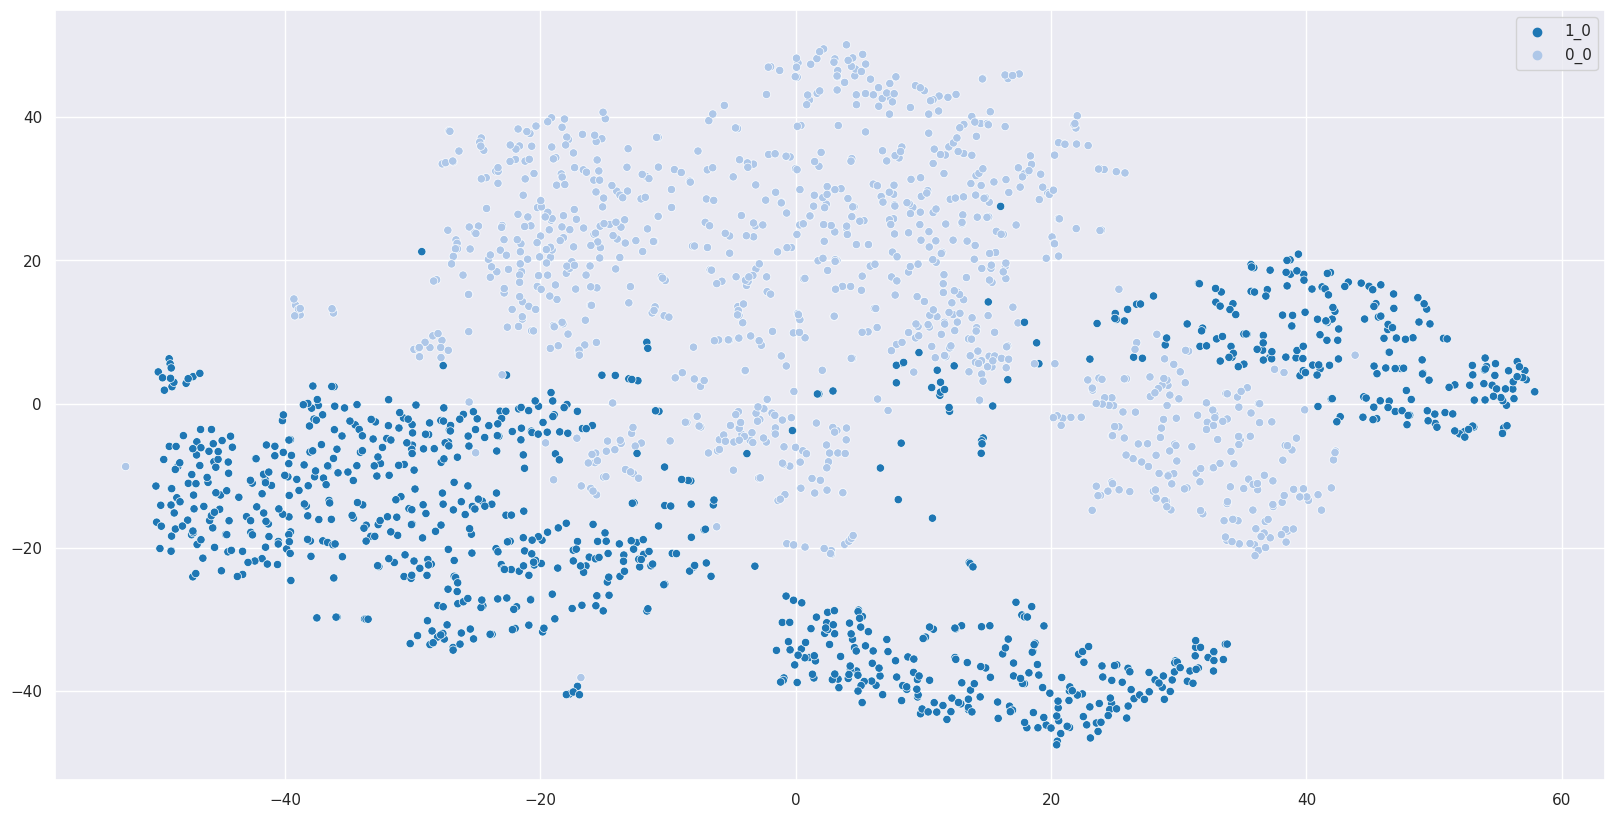

In [16]:
X_out = [] # features
y_out = [] # global labels
y_task = [] # globallabel_task_id
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        for X, y in testloader:
            X = X.to(net.device)
            X_encode = X.view(X.shape[0], -1)
            # X_encode = net.contrastive_embedding(X, task_id)
            X_out.append(X_encode.cpu())
            y_out.append(y.cpu())
            y_task.append(np.ones_like(y) * task_id)
X_encode = np.concatenate(X_out, axis=0)
Y = np.concatenate(y_out, axis=0)
y_task = np.concatenate(y_task, axis=0)
X_embedded = TSNE(n_components=2, random_state=0, init="pca", n_jobs=-1).fit_transform(X_encode)

# create an array same size as y and y_task where each element is {y}_{y_task} string
y_task_str = np.array([str(Y[i]) + "_" + str(y_task[i]) for i in range(len(Y))])
# plot X_embedded with color corresponding to y_task_str
import seaborn as sns
# different sns color palette
# bigger plot size
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette("tab20")
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_task_str);

In [17]:
agent.mode

'both'

In [18]:
trainloader = torch.utils.data.DataLoader(dataset.trainset[0],
                                            batch_size=64,
                                            shuffle=True,
                                            num_workers=0,
                                            pin_memory=True,
                                            )
agent.train(trainloader, task_id=0, num_epochs=100, testloaders=testloaders,
             train_mode='both')
            #  train_mode='ce')
            #  train_mode='cl')

INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 6.265	acc: 0.501
INFO:root:	task: avg	loss: 6.265	acc: 0.501
INFO:root:epochs: 1, training task: 0
INFO:root:	task: 0	loss: 6.245	acc: 0.501
INFO:root:	task: avg	loss: 6.245	acc: 0.501
INFO:root:epochs: 2, training task: 0
INFO:root:	task: 0	loss: 6.230	acc: 0.501
INFO:root:	task: avg	loss: 6.230	acc: 0.501
INFO:root:epochs: 3, training task: 0
INFO:root:	task: 0	loss: 6.226	acc: 0.511
INFO:root:	task: avg	loss: 6.226	acc: 0.511
INFO:root:epochs: 4, training task: 0
INFO:root:	task: 0	loss: 6.225	acc: 0.519
INFO:root:	task: avg	loss: 6.225	acc: 0.519
INFO:root:epochs: 5, training task: 0
INFO:root:	task: 0	loss: 6.223	acc: 0.533
INFO:root:	task: avg	loss: 6.223	acc: 0.533
INFO:root:epochs: 6, training task: 0
INFO:root:	task: 0	loss: 6.220	acc: 0.559
INFO:root:	task: avg	loss: 6.220	acc: 0.559
INFO:root:epochs: 7, training task: 0
INFO:root:	task: 0	loss: 6.217	acc: 0.576
INFO:root:	task: avg	loss: 6.217	acc: 0.576
INFO:roo

In [ ]:
eval_net(net, testloaders)

In [ ]:
# visualize the weights of the net
# get all the weights from net.components to a big matrix, then plt.imshow

comp_weights_after = []
for i in range(len(net.components)):
    comp_weights_after.append(net.components[i].weight.detach().cpu().numpy())
comp_weights_after = np.concatenate(comp_weights_after, axis=1)
comp_weights_diff = comp_weights_after - comp_weights_before
plt.figure(figsize=(10, 10))
plt.imshow(comp_weights_diff, cmap='gray')


In [ ]:
# visualize the decoder (classifier), weights is from net.decoder[task_id]
cls_weights_after = net.decoder[task_id].weight.detach().cpu().numpy()
cls_weights_diff = cls_weights_after - cls_weights_before
print(cls_weights_after.shape)
plt.figure(figsize=(20, 10))
plt.imshow(cls_weights_diff, cmap='gray');

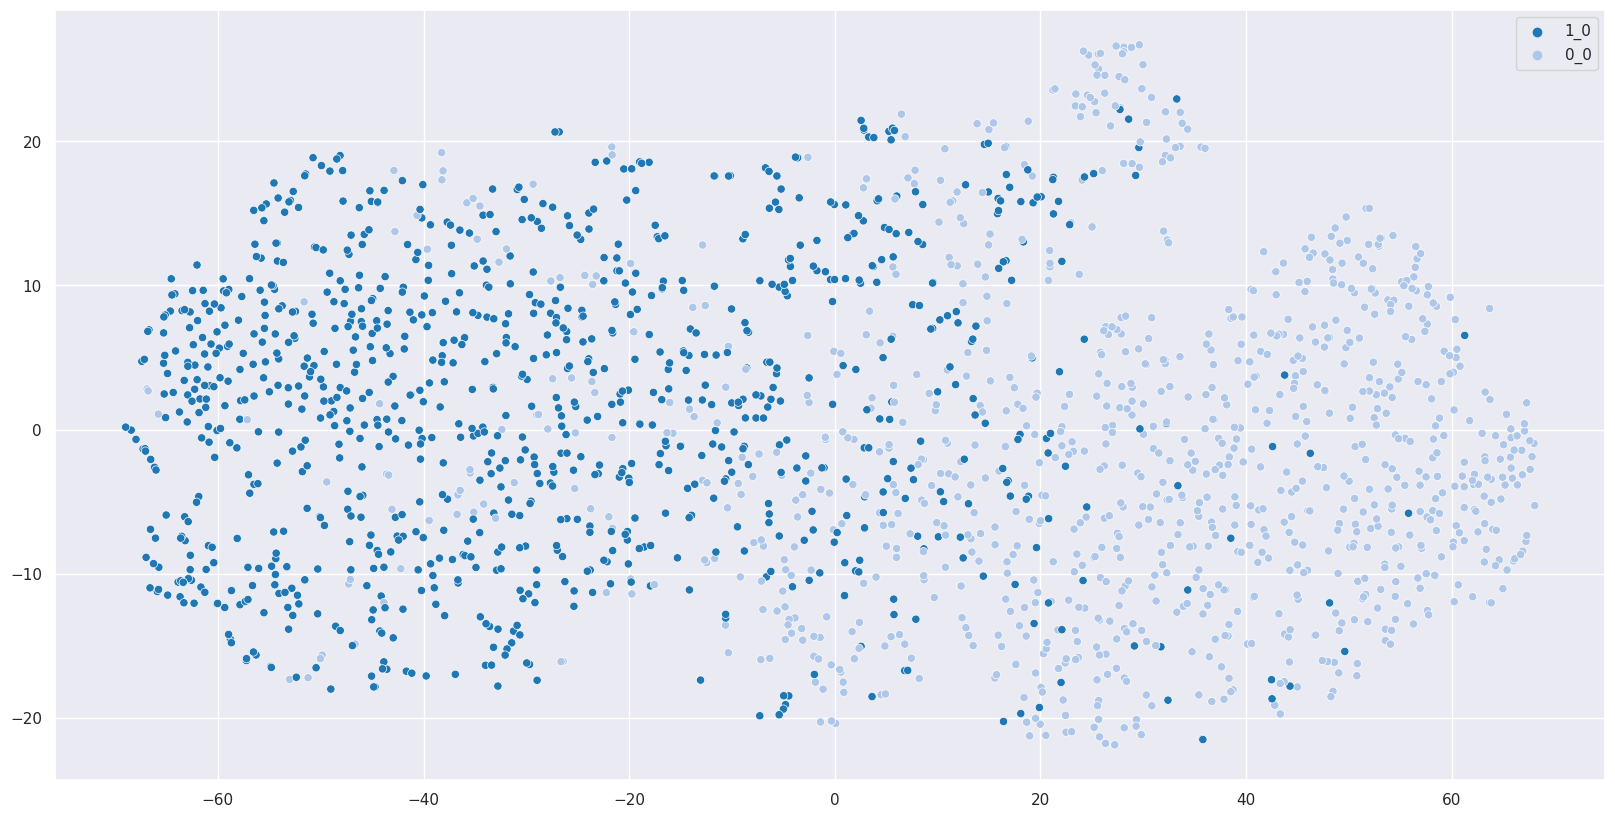

In [19]:
X_out = [] # features
y_out = [] # global labels
y_task = [] # globallabel_task_id
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        for X, y in testloader:
            X = X.to(net.device)
            X_encode = net.contrastive_embedding(X, task_id)
            X_out.append(X_encode.cpu())
            y_out.append(y.cpu())
            y_task.append(np.ones_like(y) * task_id)
X_encode = np.concatenate(X_out, axis=0)
Y = np.concatenate(y_out, axis=0)
y_task = np.concatenate(y_task, axis=0)

X_embedded = TSNE(n_components=2, random_state=0, init="pca", n_jobs=-1).fit_transform(X_encode)

# create an array same size as y and y_task where each element is {y}_{y_task} string
y_task_str = np.array([str(Y[i]) + "_" + str(y_task[i]) for i in range(len(Y))])
# plot X_embedded with color corresponding to y_task_str
# different sns color palette
# bigger plot size
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette("tab20")
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_task_str);

In [ ]:
X_embedded.shape

In [ ]:
# # train on newly shared data!
# # using both
# trainloader = torch.utils.data.DataLoader(dataset2.trainset[0],
#                                             batch_size=64,
#                                             shuffle=True,
#                                             num_workers=0,
#                                             pin_memory=True,
#                                             )
# agent.train(trainloader, task_id=0, num_epochs=100, testloaders=testloaders,
#              train_mode='both')

In [ ]:
# # train on newly shared data!
trainloader = torch.utils.data.DataLoader(dataset2.trainset[0],
                                            batch_size=64,
                                            shuffle=True,
                                            num_workers=0,
                                            pin_memory=True,
                                            )
agent.train(trainloader, task_id=0, num_epochs=100, testloaders=testloaders,
             train_mode='cl')

In [ ]:
# train on newly shared data!
trainloader = torch.utils.data.DataLoader(dataset.trainset[0],
                                            batch_size=64,
                                            shuffle=True,
                                            num_workers=0,
                                            pin_memory=True,
                                            )
agent.train(trainloader, task_id=0, num_epochs=20, testloaders=testloaders,
             train_mode='both')

 Transformation:
 KMNIST
```
 transforms.Compose([
                # transforms.RandomAffine(
                # transforms.RandomResizedCrop(
                #     size=self.net.i_size[0], scale=(0.5, 1.), antialias=True),
                transforms.RandomAffine(
                    degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1),
                    shear=0.1),
                # transforms.RandomApply([
                #                        transforms.ColorJitter(
                #                            brightness=0.2, contrast=0.2),
                #                        ], p=0.8),
                transforms.GaussianBlur(
                    kernel_size=3, sigma=(0.1, 2.0)),

            ])
```


 - 'both': accuracy from 83.7% to 86.9%. If we flip the labels. The accuracy drops to 0.519 as expected.
 - 'cl' on shared data then 'both' on my data. 'cl' part already gives 87%. At the end of 'both', accuracy jumps to 86.5%.